# Radio ML Classification - CNN Approach

Solution to the RadioML classification challenge using CNNs.

In [1]:
# Loading Data

pathToDataset = "C:/Users/aksha/Documents/Jupyter Notebooks/radioml-classification/Datasets/Standard/RML2016.10a_dict.pkl"

# Extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open(pathToDataset,'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Description of Data

The dataset has the size 220,000×2×128, which means that there are 220,000 entries, each consisting of an array of size 2 × 128. Each array represents the samples of about 128 µs of a received waveform sampled with approximately 106 samples/second, and it contains between 8 and 16 modulation symbols. Since the samples of the signal waveforms are complex-valued, they have been stored as real and imaginary parts, and therefore we have arrays of size 2 × 128 in the data set.

That is, each row is essentially, **a + ib**.

The labels of the downloaded dataset contain two parameters: the modulation technique used (one of [’8PSK’, ’AM-DSB’, ’AM-SSB’, ’BPSK’,’CPFSK’, ’GFSK’, ’PAM4’, ’QAM16’, ’QAM64’, ’QPSK’, ’WBFM’], so 11 possible modulation techniques), and the signal-to noise ratio (SNR) value (one of [−20, −18, −16, −14, −12, −10, −8, −6, −4, −2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18], so 20 possible SNR values). The SNR is a measure for the quality of the communication channel. The higher the SNR, the less “noisy” is the channel.

Each item of the list is essentially like **(b'Modulation Type',SNR Value)** [Use os.fsdecode to extract Modulation Type as string] 

In [2]:
# Import Necessary Packages
%matplotlib inline
import os
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, LayerNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import numpy as np

# Data Processing

The goal of this stage is to split data into Training, Validation and Testing data and then process the available data and transform (if needed) it into relevant inputs to be fed into the CNN.

1. Split Dataset into Training, Validation and Testing Data : 110,000 samples for training and validation and 110,000 samples for testing.

In [3]:
#  into training and test sets of the form we can train/test on 
random.seed(777)
np.random.seed(777)

index = np.arange(0,220000)
random.shuffle(index)

trainIdx = index[0:110000]
testIdx = index[110000:220000]

trainX = X[trainIdx]


# Create Validation Data Set
indexVal = np.arange(0,110000)
random.shuffle(indexVal)

realTrainIdx = indexVal[0:99000] 
valIdx = indexVal[99000:110000]

# Actual Training Data
realTrainX = trainX[realTrainIdx]
X_train = np.expand_dims(realTrainX, axis=-1) # Important

# Actual Validation Data
validX = trainX[valIdx]
X_valid = np.expand_dims(validX, axis=-1) # Important

# Actual Testing Data
testX = X[testIdx]
X_test = np.expand_dims(testX, axis=-1) # Important

In [4]:
# One Hot Encode Labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
ytrain=lbl_encoded[trainIdx]

y_train = ytrain[realTrainIdx]
y_valid = ytrain[valIdx]
y_test=lbl_encoded[testIdx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


# Design Neural Network

In [5]:
# Network Parameters
dropoutRate = 0.5

# Structure
inpShape = (2,128,1) # Shape of Input Data
CNN1_numFilt = 64 # Number of Filters in CNN Layer 1
CNN1_kernSize = (1,3) # Kernel Size of CNN Layer 1

CNN2_numFilt = 16 # Number of Filters in CNN Layer 2
CNN2_kernSize = (2,3) # Kernel Size of CNN Layer 2

Dense1_numNeurons = 128 # Number of Nodes in the First Dense Layer
numOutput = 11 # Number of Output Nodes

# Weight Initialization
weightInit = 'glorot_uniform' # Xavier Initialization

# Activation Functions
activationHidden = 'relu'
activationOutput = 'softmax'

# Loss Function
lossFunction = 'categorical_crossentropy'

# Learning Algorithm
netOptimizer = 'adam'

# Callbacks
callbackList = [
        tensorflow.keras.callbacks.ModelCheckpoint('Data/CNN-5/CNN-5-Weights_best.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')]

# Construct Network
model = models.Sequential()
model.add(BatchNormalization(axis=-1,input_shape=inpShape, name='Normalization_1'))
model.add(Convolution2D(filters=CNN1_numFilt, kernel_size=CNN1_kernSize, activation=activationHidden, name='Conv_1'))
model.add(Convolution2D(filters=CNN2_numFilt, kernel_size=CNN2_kernSize, activation=activationHidden, name='Conv_2'))
model.add(Flatten())
model.add(Dense(Dense1_numNeurons, activation=activationHidden))
model.add(Dense(numOutput, activation=activationOutput))
model.compile(loss=lossFunction, optimizer=netOptimizer,metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normalization_1 (BatchNormal (None, 2, 128, 1)         4         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 2, 126, 64)        256       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 1, 124, 16)        6160      
_________________________________________________________________
flatten (Flatten)            (None, 1984)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               254080    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1419      
Total params: 261,919
Trainable params: 261,917
Non-trainable params: 2
__________________________________________________

# Train Network

In [6]:
numEpochs = 100
batchSize = 1024

In [7]:
history = model.fit(X_train,y_train,epochs=numEpochs,batch_size=batchSize,validation_data=(X_valid,y_valid),callbacks=callbackList,verbose=2)

Train on 99000 samples, validate on 11000 samples
Epoch 1/100
99000/99000 - 9s - loss: 2.0833 - categorical_accuracy: 0.2487 - val_loss: 2.5964 - val_categorical_accuracy: 0.0940
Epoch 2/100
99000/99000 - 3s - loss: 1.8251 - categorical_accuracy: 0.3105 - val_loss: 2.5164 - val_categorical_accuracy: 0.1240
Epoch 3/100
99000/99000 - 3s - loss: 1.6924 - categorical_accuracy: 0.3537 - val_loss: 2.4566 - val_categorical_accuracy: 0.1333
Epoch 4/100
99000/99000 - 3s - loss: 1.5922 - categorical_accuracy: 0.3898 - val_loss: 2.5676 - val_categorical_accuracy: 0.1416
Epoch 5/100
99000/99000 - 3s - loss: 1.5230 - categorical_accuracy: 0.4108 - val_loss: 2.3943 - val_categorical_accuracy: 0.1929
Epoch 6/100
99000/99000 - 3s - loss: 1.4743 - categorical_accuracy: 0.4267 - val_loss: 2.2174 - val_categorical_accuracy: 0.2316
Epoch 7/100
99000/99000 - 3s - loss: 1.4342 - categorical_accuracy: 0.4479 - val_loss: 1.9045 - val_categorical_accuracy: 0.2820
Epoch 8/100
99000/99000 - 2s - loss: 1.3784 - c

Epoch 64/100
99000/99000 - 2s - loss: 0.2971 - categorical_accuracy: 0.8891 - val_loss: 3.8985 - val_categorical_accuracy: 0.4748
Epoch 65/100
99000/99000 - 3s - loss: 0.2923 - categorical_accuracy: 0.8920 - val_loss: 3.9950 - val_categorical_accuracy: 0.4710
Epoch 66/100
99000/99000 - 3s - loss: 0.2776 - categorical_accuracy: 0.8962 - val_loss: 4.0840 - val_categorical_accuracy: 0.4761
Epoch 67/100
99000/99000 - 3s - loss: 0.2883 - categorical_accuracy: 0.8920 - val_loss: 4.1094 - val_categorical_accuracy: 0.4701
Epoch 68/100
99000/99000 - 3s - loss: 0.2869 - categorical_accuracy: 0.8915 - val_loss: 4.1942 - val_categorical_accuracy: 0.4707
Epoch 69/100
99000/99000 - 3s - loss: 0.2614 - categorical_accuracy: 0.9020 - val_loss: 4.3048 - val_categorical_accuracy: 0.4691
Epoch 70/100
99000/99000 - 3s - loss: 0.2458 - categorical_accuracy: 0.9083 - val_loss: 4.3931 - val_categorical_accuracy: 0.4736
Epoch 71/100
99000/99000 - 2s - loss: 0.2501 - categorical_accuracy: 0.9058 - val_loss: 4.

In [15]:
# Save History
np_loss_history = np.array(history.history["loss"])
np.save('Data/CNN-5/lossHist.npy',np_loss_history)

np_accu_history = np.array(history.history["categorical_accuracy"])
np.save('Data/CNN-5/accuHist.npy',np_accu_history)

np_val_loss_history = np.array(history.history["val_loss"])
np.save('Data/CNN-5/valLossHist.npy',np_val_loss_history)

np_val_accu_history = np.array(history.history["val_categorical_accuracy"])
np.save('Data/CNN-5/valAccuHist.npy',np_val_accu_history)

# Test/Evaluate Network

In [6]:
# Re-load Best Weights
model.load_weights('Data/CNN-5/CNN-5-Weights_best.h5')

model.evaluate(X_test,y_test)

110000/110000 [==============================] - 23s 208us/sample - loss: 1.3371 - categorical_accuracy: 0.4928


[1.3371440863869406, 0.4928]

# Visualize Results

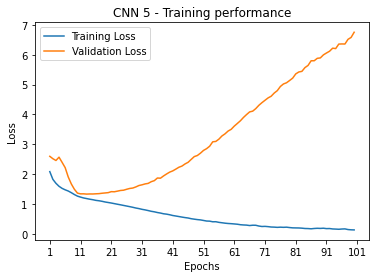

In [7]:
# Load Details of History
lHist = np.load('Data/CNN-5/lossHist.npy')
aHist = np.load('Data/CNN-5/accuHist.npy')

vLHist = np.load('Data/CNN-5/valLossHist.npy')
vAHist = np.load('Data/CNN-5/valAccuHist.npy')

# Show loss curves 
plt.figure()
plt.title('CNN 5 - Training performance')
plt.plot(lHist, label='Training Loss')
plt.plot(vLHist, label='Validation Loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(0,110,10),np.arange(1,111,10))
plt.ylabel('Loss')
plt.legend()

In [8]:
# Function to Extract Test Data of Specific SNR
def extractTest(data,labels,labelsEncoded,testIndex,snr):
    testData = data[testIndex]
    labelArray = np.array([labels])
    testLabels = labelArray[:,testIdx,:]
    testLabelsEncoded = labelsEncoded[testIdx]
    
    idxOP = list()
    
    # Loop Through Label Array To Get Index of Specific SNR
    for i in range(0,testLabels.shape[1]):
        if testLabels[0,i,1].decode('ascii')==snr:
            idxOP.append(i)
    
    # Return Subset of Test Data and Corresponding Labels
    opTestData = np.expand_dims(testData[idxOP,:,:],axis=-1)
    opTestLabel = testLabelsEncoded[idxOP]
    
    return opTestData, opTestLabel

def plot_confusion_matrix(cm, titleAdd, title='CNN 5 - Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+titleAdd)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Confusion Matrix Function
def prepConfMat(testData,testLabel,predTestLabel,mods,title):
    modString = list()
    for i in range(0,len(mods)):
        modString.append(mods[i].decode('ascii'))
    
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,testData.shape[0]):
        j = list(testLabel[i,:]).index(1)
        k = int(np.argmax(predTestLabel[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, title, labels=modString)

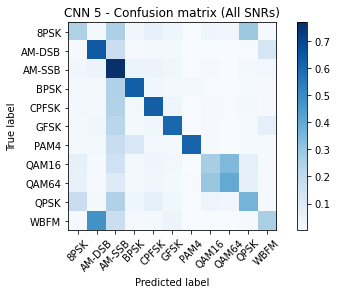

In [9]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=1024)

prepConfMat(X_test,y_test,test_Y_hat,mods,' (All SNRs)')

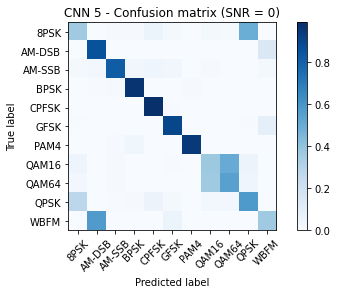

In [10]:
# Plot Confusion Matrix for Specific SNR
snr = '0'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
y_hat_snr = model.predict(x_testSNR, batch_size=1024)
prepConfMat(x_testSNR,y_TestSNR,y_hat_snr,mods,title)

In [11]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[testIdx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.096593980897459 for SNR b'-20'
Overall Accuracy:  0.09912854030501089 for SNR b'-18'
Overall Accuracy:  0.1015182001097494 for SNR b'-16'
Overall Accuracy:  0.12181818181818181 for SNR b'-14'
Overall Accuracy:  0.15303003057004136 for SNR b'-12'
Overall Accuracy:  0.21707988980716253 for SNR b'-10'
Overall Accuracy:  0.3124658780709736 for SNR b'-8'
Overall Accuracy:  0.45143884892086333 for SNR b'-6'
Overall Accuracy:  0.5740435658063335 for SNR b'-4'
Overall Accuracy:  0.6580597565473995 for SNR b'-2'
Overall Accuracy:  0.7026296829971181 for SNR b'0'
Overall Accuracy:  0.7081269491836361 for SNR b'2'
Overall Accuracy:  0.7051029543419874 for SNR b'4'
Overall Accuracy:  0.7103510351035104 for SNR b'6'
Overall Accuracy:  0.7130111524163569 for SNR b'8'
Overall Accuracy:  0.7058823529411765 for SNR b'10'
Overall Accuracy:  0.6964937910883857 for SNR b'12'
Overall Accuracy:  0.7232011747430249 for SNR b'14'
Overall Accuracy:  0.7046198617679156 for SNR b'16'
Overall

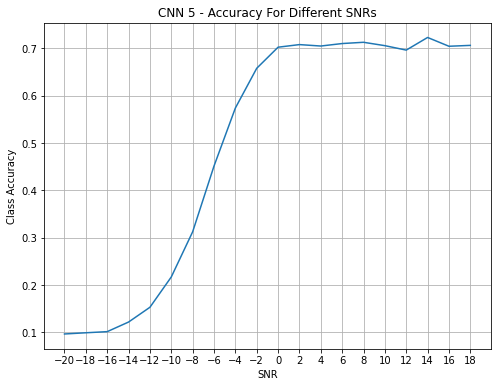

In [12]:
# Show loss curves 
plt.figure(figsize=(8, 6))
plt.title('CNN 5 - Accuracy For Different SNRs')
plt.plot(np.arange(-20,20,2), acc_array)
plt.xlabel('SNR')
plt.xticks(np.arange(-20,20,2))
plt.ylabel('Class Accuracy')
plt.grid()
plt.show()

In [13]:
accRes = np.array([acc_array])
np.save('Data/CNN-5/accResSNR.npy',accRes)